In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
import tflearn
import tensorflow as tf
import gc

from PCA import PCA
from Autoencoder import Autoencoder
from RBM import RBM
from classify import classification

%matplotlib inline

In [2]:
# Data loading and preprocessing
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/', one_hot=True)

# get detailed data
train_img = mnist.train.images
train_label = mnist.train.labels

cv_img = mnist.validation.images
cv_label = mnist.validation.labels

test_img = mnist.test.images
test_label = mnist.test.labels

train_single_label = np.argmax(train_label, axis=1)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
# define colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#7FFFD4', '#9ACD32', '#FFA500']

# Classification using raw data

In [4]:
train_acc, test_acc = classification(train_img, train_label, test_img, test_label, 
                                     dim_input=784, dim_output=10, n_epoch=20, 
                                     cv_x=cv_img, cv_y=cv_label)

print('training accuracy is {0:5f}, test accuracy is {1:5f}'.format(train_acc, test_acc))

Training Step: 17200  | total loss: 0.51444
| Adam | epoch: 020 | loss: 0.51444 | val_loss: 0.26425 -- iter: 55000/55000
Training Step: 17200  | total loss: 0.51444
| Adam | epoch: 020 | loss: 0.51444 | val_loss: 0.26425 -- iter: 55000/55000
--
training accuracy is 0.930764, test accuracy is 0.925600


# Autoencoder Model

In [5]:
layer1 = [128, 256, 512]
layer2 = [16, 32, 64, 128, 256] 
folder = '/media/jifu/F268088F680854AF/ECE544_Data/Autoencoder/'

for i in layer1:
    for j in layer2:
        layers = (784, i, j, i, 784)
        train_en_path = folder + str(i) + '_' + str(j) + '_train_en.npy'
        train_de_path = folder + str(i) + '_' + str(j) + '_train_de.npy'
        cv_en_path = folder + str(i) + '_' + str(j) + '_cv_en.npy'
        cv_de_path = folder + str(i) + '_' + str(j) + '_cv_de.npy'
        test_en_path = folder + str(i) + '_' + str(j) + '_test_en.npy'
        test_de_path = folder + str(i) + '_' + str(j) + '_test_de.npy'
        
        # build the auto-encoder model
        autoencoder = Autoencoder(layers=layers, init_w=None, init_b=None, 
                                  num_cores=6, gpu_memory_fraction=0.6)
        # train auto-encoder model
        train_en, train_de, cv_en, cv_de, test_en, test_de = \
            autoencoder.train(train_img, cv_img, test_img, n_epoch=20, batch_size=256)
            
        np.save(train_en_path, train_en)
        np.save(train_de_path, train_de)
        np.save(cv_en_path, cv_en)
        np.save(cv_de_path, cv_de)
        np.save(test_en_path, test_en)
        np.save(test_de_path, test_de)
        
        print('Finish layers:', layers, '!')
        gc.collect()
        
print('Autoencoder training process is finished !')

Training Step: 4300  | total loss: 0.00841
| Adam | epoch: 020 | loss: 0.00841 | val_loss: 0.00845 -- iter: 55000/55000
Training Step: 4300  | total loss: 0.00841
| Adam | epoch: 020 | loss: 0.00841 | val_loss: 0.00845 -- iter: 55000/55000
--
Training process is finished !
Finish layers: (784, 512, 256, 512, 784) !
Autoencoder training process is finished !


## Classification

In [6]:
layer1 = [128, 256, 512]
layer2 = [16, 32, 64, 128, 256] 
folder = '/media/jifu/F268088F680854AF/ECE544_Data/Autoencoder/'

with open('./result/Autoencoder.txt', 'w') as f:
    for i in layer1:
        for j in layer2:
            layers = (784, i, j, i, 784)
            train_en_path = folder + str(i) + '_' + str(j) + '_train_en.npy'
            cv_en_path = folder + str(i) + '_' + str(j) + '_cv_en.npy'
            test_en_path = folder + str(i) + '_' + str(j) + '_test_en.npy'

            # load the trained feature
            train_en = np.load(train_en_path)
            cv_en = np.load(cv_en_path)
            test_en = np.load(test_en_path)

            # classification
            train_acc, test_acc = classification(train_en, train_label, test_en, test_label, 
                                                 dim_input=j, dim_output=10, 
                                                 cv_x=cv_en, cv_y=cv_label, n_epoch=20)

            f.write('{0:26s} training accuracy is {1:5f}, test accuracy is {2:5f}\n'\
                    .format(str(layers), train_acc, test_acc))
        
print('Autoencoder classification process is finished !')

Training Step: 17200  | total loss: 0.46114
| Adam | epoch: 020 | loss: 0.46114 | val_loss: 0.21901 -- iter: 55000/55000
Training Step: 17200  | total loss: 0.46114
| Adam | epoch: 020 | loss: 0.46114 | val_loss: 0.21901 -- iter: 55000/55000
--
Autoencoder classification process is finished !


# Visualization

### PCA for auto-encoder

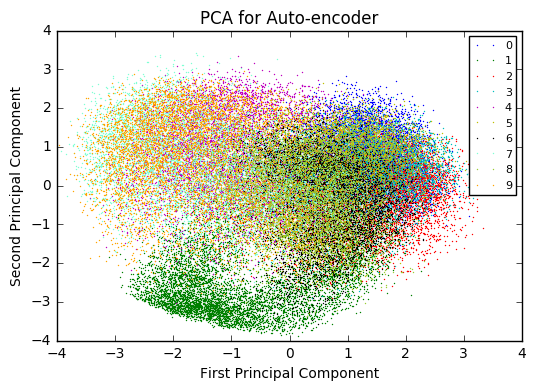

In [7]:
# visualize the representation learned by Auto-encoder
train_en = np.load('/media/jifu/F268088F680854AF/ECE544_Data/Autoencoder/512_256_train_en.npy')

pca = PCA()
pca.fit(train_en)
train_en_pca = pca.transform(train_en)

# visualization
fig, ax = plt.subplots()
for i in range(10):
    tmp = train_en_pca[train_single_label == i, :2]
    plt.plot(tmp[:, 0], tmp[:, 1], '.', color=colors[i], markersize=1, label=str(i))
ax.set_title('PCA for Auto-encoder')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend(fontsize=8, loc='best')
fig.savefig('./result/autoencoder.pdf')
fig.savefig('./result/autoencoder.png', dpi=300)
plt.show()

### Training samples

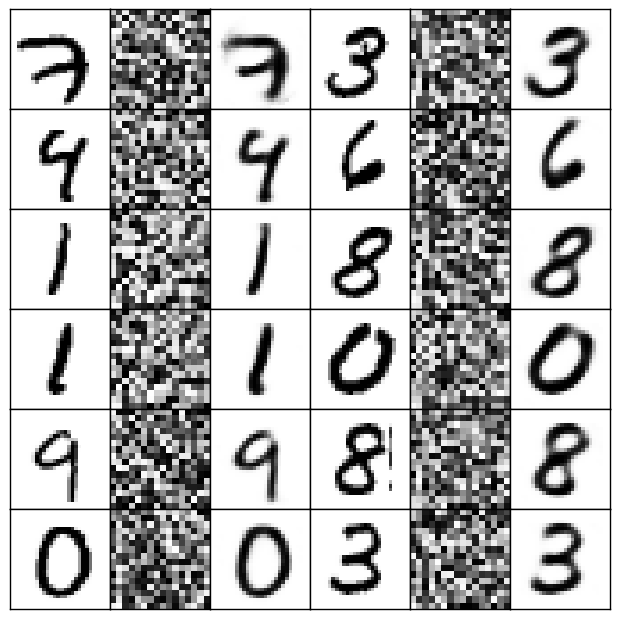

In [8]:
# visualize the representation learned by Auto-encoder
train_en = np.load('/media/jifu/F268088F680854AF/ECE544_Data/Autoencoder/512_256_train_en.npy')
test_en = np.load('/media/jifu/F268088F680854AF/ECE544_Data/Autoencoder/512_256_test_en.npy')
train_de = np.load('/media/jifu/F268088F680854AF/ECE544_Data/Autoencoder/512_256_train_de.npy')
test_de = np.load('/media/jifu/F268088F680854AF/ECE544_Data/Autoencoder/512_256_test_de.npy')

# training set example
n = 6  # the index of image want to show
m = 16  # the shape of encoded image
fig, ax = plt.subplots(nrows=n, ncols=6, figsize=(6, 6))
for i in range(n):
    for j in range(2):
        ax[i, 3*j].imshow(np.reshape(train_img[2*i + j, :], (28, 28)), 
                        cmap=plt.cm.gray_r, interpolation='none')
    #     ax[i, 0].set_title('Original Digit')
        ax[i, 3*j].set_xticks([])
        ax[i, 3*j].set_yticks([])
        ax[i, 3*j].axis('image')

        ax[i, 3*j+1].imshow(np.reshape(train_en[2*i + j, :], (m, m)), 
                        cmap=plt.cm.gray_r, interpolation='none')
    #     ax[i, 1].set_title('Encoded Digit')
        ax[i, 3*j+1].set_xticks([])
        ax[i, 3*j+1].set_yticks([])
        ax[i, 3*j+1].axis('image')

        ax[i, 3*j+2].imshow(np.reshape(train_de[2*i + j, :], (28, 28)), 
                     cmap=plt.cm.gray_r, interpolation='none')
    #     ax[i, 2].set_title('Reconstructed Digit')
        ax[i, 3*j+2].set_xticks([])
        ax[i, 3*j+2].set_yticks([])
        ax[i, 3*j+2].axis('image')
        
plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=None)   
plt.show()

### Test samples

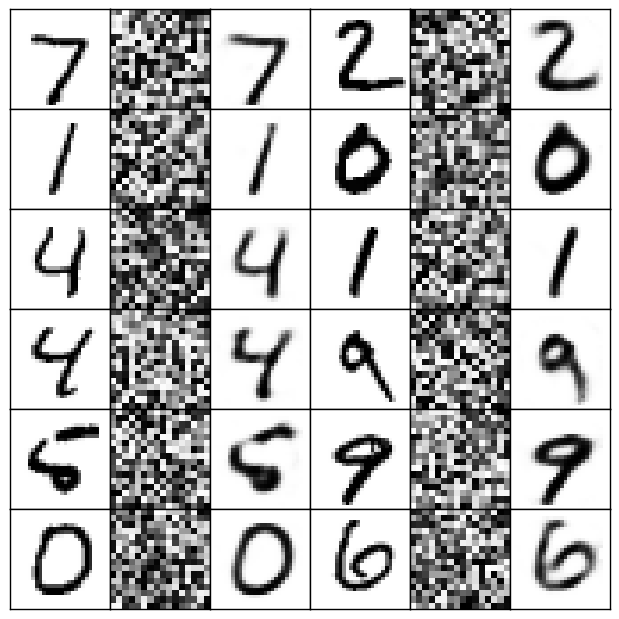

In [9]:
# test set example
n = 6  # the index of image want to show
m = 16  # the shape of encoded image
fig, ax = plt.subplots(nrows=n, ncols=6, figsize=(6, 6))
for i in range(n):
    for j in range(2):
        ax[i, 3*j].imshow(np.reshape(test_img[2*i + j, :], (28, 28)), 
                        cmap=plt.cm.gray_r, interpolation='none')
    #     ax[i, 0].set_title('Original Digit')
        ax[i, 3*j].set_xticks([])
        ax[i, 3*j].set_yticks([])
        ax[i, 3*j].axis('image')

        ax[i, 3*j+1].imshow(np.reshape(test_en[2*i + j, :], (m, m)), 
                        cmap=plt.cm.gray_r, interpolation='none')
    #     ax[i, 1].set_title('Encoded Digit')
        ax[i, 3*j+1].set_xticks([])
        ax[i, 3*j+1].set_yticks([])
        ax[i, 3*j+1].axis('image')

        ax[i, 3*j+2].imshow(np.reshape(test_de[2*i + j, :], (28, 28)), 
                     cmap=plt.cm.gray_r, interpolation='none')
    #     ax[i, 2].set_title('Reconstructed Digit')
        ax[i, 3*j+2].set_xticks([])
        ax[i, 3*j+2].set_yticks([])
        ax[i, 3*j+2].axis('image')
        
plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=None)   
plt.show()

# Autoencoder Model with RBM

In [4]:
layer1 = [128, 256, 512]
layer2 = [16, 32, 64, 128, 256] 
folder = '/media/jifu/F268088F680854AF/ECE544_Data/RBM/'

for i in layer1:
    for j in layer2:
        layers = (784, i, j, i, 784)
        train_en_path = folder + str(i) + '_' + str(j) + '_train_en.npy'
        train_de_path = folder + str(i) + '_' + str(j) + '_train_de.npy'
        cv_en_path = folder + str(i) + '_' + str(j) + '_cv_en.npy'
        cv_de_path = folder + str(i) + '_' + str(j) + '_cv_de.npy'
        test_en_path = folder + str(i) + '_' + str(j) + '_test_en.npy'
        test_de_path = folder + str(i) + '_' + str(j) + '_test_de.npy'
        
        # build the first RBM model
        rbm1 = RBM(visible_nodes=784, hidden_nodes=i, learning_rate=0.001, batch_size=10, n_iter=10)
        w1, b1, c1 = rbm1.train(train_img)
        # calculate the output of the first RBM on training and testing dataset
        train_rbm1 = 1 / (1 + np.exp(-np.dot(train_img, w1.T) + c1))
        
        # build the second RBM model
        rbm2 = RBM(visible_nodes=i, hidden_nodes=j, learning_rate=0.001, batch_size=10, n_iter=10)
        w2, b2, c2 = rbm2.train(train_rbm1)
        
        init_w = (w1.T, w2.T, w2, w1)
        init_b = (c1, c2, b2, b1)
        
        # build the auto-encoder model
        autoencoder = Autoencoder(layers=layers, init_w=init_w, init_b=init_b, 
                                  num_cores=6, gpu_memory_fraction=0.6)
        # train auto-encoder model
        train_en, train_de, cv_en, cv_de, test_en, test_de = \
            autoencoder.train(train_img, cv_img, test_img, n_epoch=10, batch_size=256)
            
        np.save(train_en_path, train_en)
        np.save(train_de_path, train_de)
        np.save(cv_en_path, cv_en)
        np.save(cv_de_path, cv_de)
        np.save(test_en_path, test_en)
        np.save(test_de_path, test_de)
        
        print('Finish layers:', layers, '!')
        gc.collect()
        
print('Autoencoder with RBM training process is finished !')

Training Step: 2150  | total loss: 0.00556
| Adam | epoch: 010 | loss: 0.00556 | val_loss: 0.00405 -- iter: 55000/55000
Training Step: 2150  | total loss: 0.00556
| Adam | epoch: 010 | loss: 0.00556 | val_loss: 0.00405 -- iter: 55000/55000
--
Training process is finished !
Finish layers: (784, 512, 256, 512, 784) !
Autoencoder with RBM training process is finished !


## Classification

In [5]:
layer1 = [128, 256, 512]
layer2 = [16, 32, 64, 128, 256] 
folder = '/media/jifu/F268088F680854AF/ECE544_Data/RBM/'

with open('./result/Autoencoder_RBM.txt', 'w') as f:
    for i in layer1:
        for j in layer2:
            layers = (784, i, j, i, 784)
            train_en_path = folder + str(i) + '_' + str(j) + '_train_en.npy'
            cv_en_path = folder + str(i) + '_' + str(j) + '_cv_en.npy'
            test_en_path = folder + str(i) + '_' + str(j) + '_test_en.npy'

            # load the trained feature
            train_en = np.load(train_en_path)
            cv_en = np.load(cv_en_path)
            test_en = np.load(test_en_path)

            # classification
            train_acc, test_acc = classification(train_en, train_label, test_en, test_label, 
                                                 dim_input=j, dim_output=10, 
                                                 cv_x=cv_en, cv_y=cv_label, n_epoch=20)

            f.write('{0:26s} training accuracy is {1:5f}, test accuracy is {2:5f}\n'\
                    .format(str(layers), train_acc, test_acc))
        
print('Autoencoder classification process is finished !')

Training Step: 17200  | total loss: 0.18234
| Adam | epoch: 020 | loss: 0.18234 | val_loss: 0.20266 -- iter: 55000/55000
Training Step: 17200  | total loss: 0.18234
| Adam | epoch: 020 | loss: 0.18234 | val_loss: 0.20266 -- iter: 55000/55000
--
Autoencoder classification process is finished !


# Deep Autoencoder (test)

In [12]:
# layers = (784, 512, 64, 512, 784)

# # build the auto-encoder model
# autoencoder = Autoencoder(layers=layers, init_w=None, init_b=None, 
#                           num_cores=6, gpu_memory_fraction=0.6)
# # train auto-encoder model
# train_en, train_de, cv_en, cv_de, test_en, test_de = \
#     autoencoder.train(train_img, cv_img, test_img, n_epoch=15, batch_size=256)

# # classification
# train_acc, test_acc = classification(train_en, train_label, test_en, test_label, 
#                                      dim_input=layers[2], dim_output=10, 
#                                      cv_x=cv_en, cv_y=cv_label, n_epoch=20)

# print('training accuracy is {0:5f}, test accuracy is {1:5f}'.format(train_acc, test_acc))